# 1. Loading necessary modules

In [1]:
%matplotlib inline

from math import floor, ceil

# for seaborn issue:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
# import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, PassiveAggressiveClassifier, RandomizedLogisticRegression, RidgeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Loading the data

In [2]:
train = pd.read_csv("Input/train.csv")
test = pd.read_csv("Input/test.csv")

train=train.rename(columns={'final_status':'funded'})

# 3. Cleaning the data required

Converting the different currency to a USD

In [3]:
train['currency'].unique()

array(['USD', 'GBP', 'CAD', 'AUD', 'NZD', 'EUR', 'SEK', 'NOK', 'DKK'], dtype=object)

In [4]:
curr_conveter={'USD':1, 'GBP':1.27, 'CAD':0.75, 'AUD':0.76, 'NZD':0.73, 'EUR':1.12, 'SEK':0.11, 'NOK':0.12, 'DKK':0.15}

In [5]:
train['curr_value']=train['currency'].map(curr_conveter)
test['curr_value']=test['currency'].map(curr_conveter)

In [6]:
train['funding_USD']=train['goal']*train['curr_value']
test['funding_USD']=test['goal']*test['curr_value']

In [7]:
train=train.drop(['curr_value', 'goal', 'currency'], 1)
test=test.drop(['curr_value', 'goal', 'currency'], 1)

train=train.rename(columns={'funding_USD': 'goal'})
test=test.rename(columns={'funding_USD': 'goal'})

Converting the unnix date columns in datetime

In [8]:
required_cols=['deadline', 'state_changed_at', 'created_at', 'launched_at']

for col in required_cols:
    train[col]=pd.to_datetime(train[col], unit='s')
    test[col]=pd.to_datetime(test[col], unit='s')

Finding if *state_changed* is before *deadline*

In [9]:
train['state_changed_before']=train['state_changed_at']<train['deadline']
test['state_changed_before']=test['state_changed_at']<test['deadline']

Finding the difference between the launched and deadline dates.

In [10]:
train['d_l_diff']=(train['deadline']-train['launched_at'])/np.timedelta64(1, 'h')
test['d_l_diff']=(test['deadline']-test['launched_at'])/np.timedelta64(1, 'h')

Finding the difference between the created and launched dates

In [11]:
train['l_c_diff']=(train['launched_at']-train['created_at'])/np.timedelta64(1, 'h')
test['l_c_diff']=(test['launched_at']-test['created_at'])/np.timedelta64(1, 'h')

Find the length of the name, desc, keywords

In [12]:
required_cols=['name', 'desc', 'keywords']

def get_length(row, *args):
    try:
        col=args[0]
        return len(row[col])
    except:
        return np.NaN

for col in required_cols:
    train[col+'_len']=train.apply(get_length, axis=1, args=[col])
    test[col+'_len']=test.apply(get_length, axis=1, args=[col])

In [13]:
train.head(3)

,project_id,name,desc,keywords,disable_communication,country,deadline,state_changed_at,created_at,launched_at,backers_count,funded,goal,state_changed_before,d_l_diff,l_c_diff,name_len,desc_len,keywords_len
0,kkst1451568084,drawing for dollars,I like drawing pictures. and then i color them...,drawing-for-dollars,False,US,2009-05-03 06:59:59,2009-05-03 07:00:17,2009-04-24 19:15:07,2009-04-24 19:52:03,3,1,20.0,False,203.132222,0.615556,19.0,134.0,19
1,kkst1474482071,Sponsor Dereck Blackburn (Lostwars) Artist in ...,"I, Dereck Blackburn will be taking upon an inc...",sponsor-dereck-blackburn-lostwars-artist-in-re...,False,US,2009-05-15 23:10:00,2009-05-16 00:00:18,2009-04-28 23:10:24,2009-04-29 03:26:32,2,0,300.0,False,403.724444,4.268889,76.0,137.0,74
2,kkst183622197,Mr. Squiggles,So I saw darkpony's successfully funded drawin...,mr-squiggles,False,US,2009-05-22 21:26:00,2009-05-22 21:30:18,2009-05-12 21:26:53,2009-05-12 21:39:58,0,0,30.0,False,239.767222,0.218056,13.0,385.0,12


Checking the empty values.

In [14]:
print(train.isnull().sum())

project_id               0
name                     1
desc                     8
keywords                 0
disable_communication    0
country                  0
deadline                 0
state_changed_at         0
created_at               0
launched_at              0
backers_count            0
funded                   0
goal                     0
state_changed_before     0
d_l_diff                 0
l_c_diff                 0
name_len                 1
desc_len                 8
keywords_len             0
dtype: int64


# 4. Analysing the data

### Checking the percentage of the funded projects.

In [15]:
funded=train[train['funded']==1]
non_funded=train[train['funded']==0]

print('Funded: %i (%.1f percent), Non funded: %i (%.1f percent), Total: %i'\
      %(len(funded), len(funded)/len(train)*100,
        len(non_funded), len(non_funded)/len(train)*100, len(train)))

Funded: 34561 (32.0 percent), Non funded: 73568 (68.0 percent), Total: 108129


In our training data set, only about **32%** of the the project got funded.

### Checking the funded project w.r.t to *disable_communication*

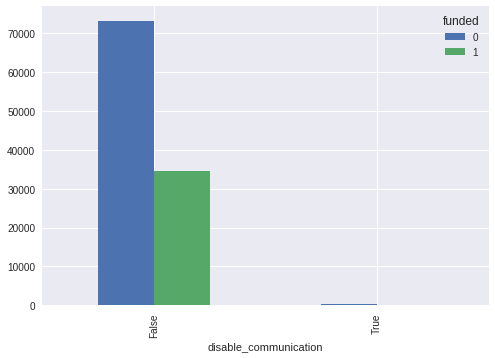

In [16]:
pd.crosstab(train['disable_communication'], train['funded']).plot(kind='bar')

All funded projects have *disabled_communication* as *false*

### Checking the funded projects w.r.t to the country of origin

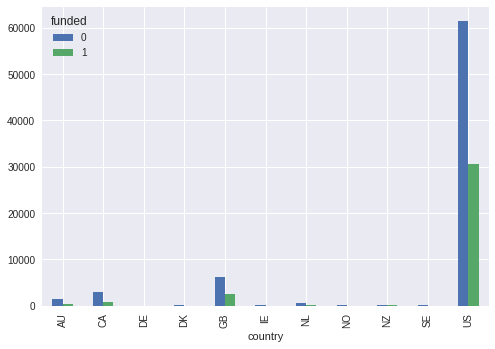

In [17]:
pd.crosstab(train['country'], train['funded']).plot(kind='bar')

So we have *US* with more funded and non funded projects. Therefore there is a large possibility of projects getting funded if the country of origin is *US*.

### Checking the funded projects w.r.t to the state changed before deadline

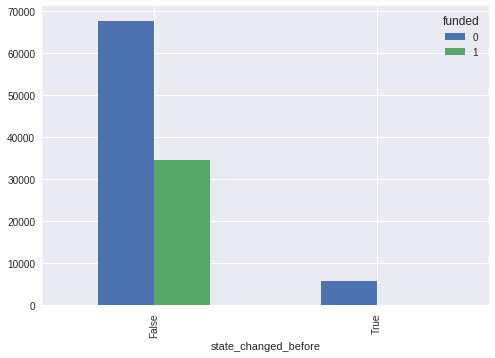

In [18]:
pd.crosstab(train['state_changed_before'], train['funded']).plot(kind='bar')

So all the  projects which got its state changed before deadline was not funded.

### Finding the mean of the difference between the creating and launching the project

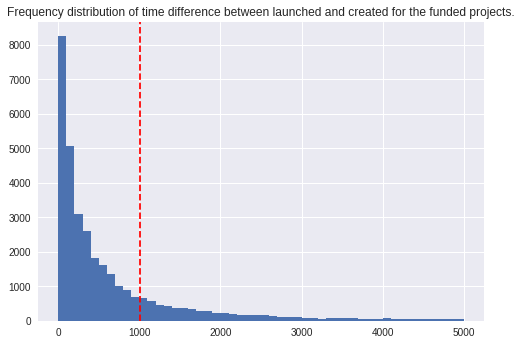

In [19]:
funded.hist(column='l_c_diff', bins=range(0,5000+100,100))
plt.axvline(funded['l_c_diff'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of time difference between launched and created for the funded projects.')

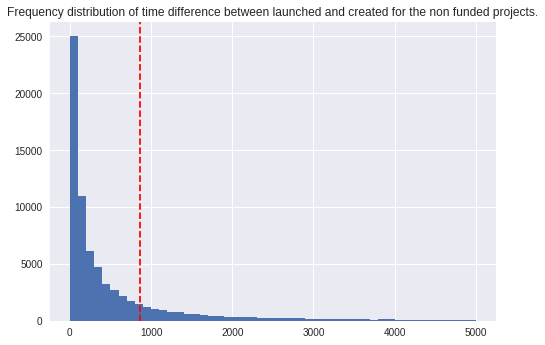

In [20]:
non_funded.hist(column='l_c_diff', bins=range(0,5000+100,100))
plt.axvline(non_funded['l_c_diff'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of time difference between launched and created for the non funded projects.')

So, the mean hours after creating the funded project is around 1000 and for non funded projects is around 900.

### Finding the mean of the launch and deadline of the project

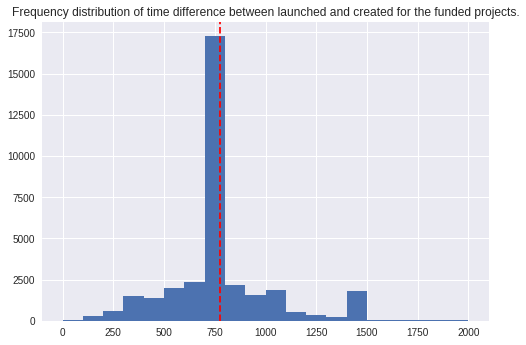

In [21]:
funded.hist(column='d_l_diff', bins=range(0,2000+100,100))
plt.axvline(funded['d_l_diff'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of time difference between launched and created for the funded projects.')

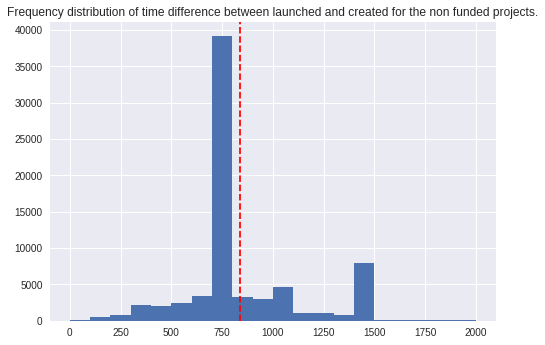

In [22]:
non_funded.hist(column='d_l_diff', bins=range(0,2000+100,100))
plt.axvline(non_funded['d_l_diff'].mean(), color='r', linestyle='dashed')
plt.title('Frequency distribution of time difference between launched and created for the non funded projects.')

The average time between launching and deadline of funded project is around 760. But for non funded projects it's around 800.

# 5. Checking the relationships between the variables

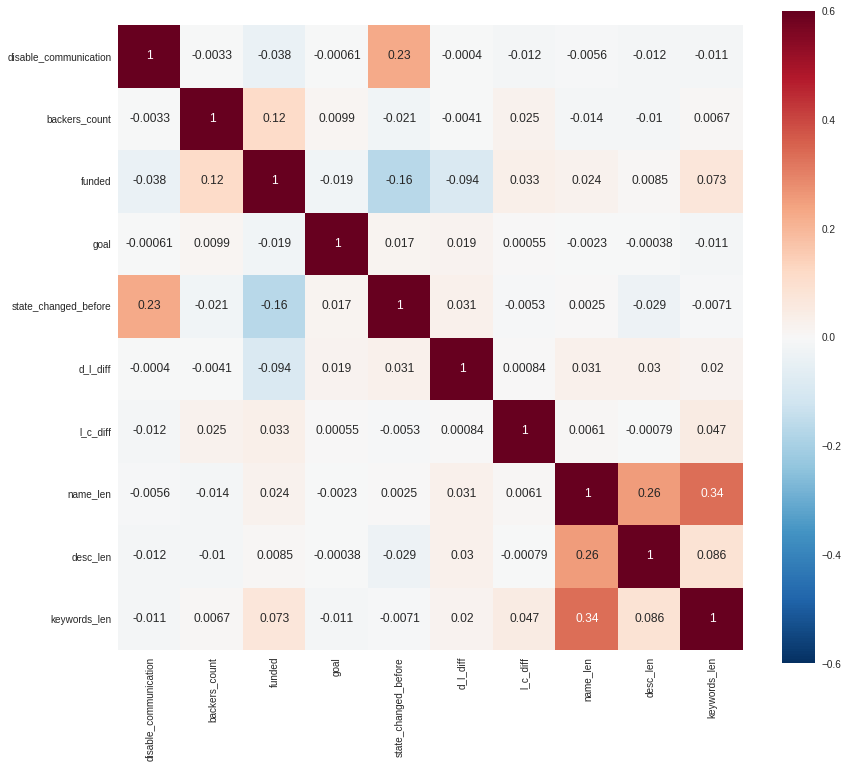

In [23]:
plt.figure(figsize=(14,12))
foo = sns.heatmap(train.drop(['project_id', 'name', 'desc', 'keywords'],axis=1).corr(), vmax=0.6, square=True, annot=True)

# 6. Preparing for modelling

In [24]:
combine = pd.concat([train.drop('funded',1),test])
funded=train['funded']

combine["country"] = combine["country"].astype("category")
combine["country"].cat.categories = [0,1,2,3,4,5,6,7,8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
combine["country"] = combine["country"].astype("int")

combine["disable_communication"] = combine["disable_communication"].astype("category")
combine["disable_communication"].cat.categories = [0,1]
combine["disable_communication"] = combine["disable_communication"].astype("int")

combine["state_changed_before"] = combine["state_changed_before"].astype("category")
combine["state_changed_before"].cat.categories = [0,1]
combine["state_changed_before"] = combine["state_changed_before"].astype("int")

test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['funded'] = funded

train.loc[:,["country","disable_communication"]].head()

,country,disable_communication
0,20,0
1,20,0
2,20,0
3,20,0
4,20,0


# 7. Modelling

In [25]:
training, testing = train_test_split(train, test_size=0.2, random_state=0)
print("Total sample size = %i; training sample size = %i, testing sample size = %i"\
     %(train.shape[0],training.shape[0],testing.shape[0]))

Total sample size = 108129; training sample size = 86503, testing sample size = 21626


In [26]:
cols = ['country','d_l_diff','desc_len','disable_communication',
        'goal','keywords_len','l_c_diff','name_len','state_changed_before']
tcols = np.append(['funded'],cols)

df = training.loc[:,tcols].dropna()
X = df.loc[:,cols]
y = np.ravel(df.loc[:,['funded']])

**Logistic Regression**

In [27]:
clf_log = LogisticRegression()
clf_log = clf_log.fit(X,y)
score_log = clf_log.score(X,y)
print(score_log)

0.677680790797


**Perceptron**

In [28]:
clf_pctr = Perceptron(
    class_weight='balanced'
    )
clf_pctr = clf_pctr.fit(X,y)
score_pctr = cross_val_score(clf_pctr, X, y, cv=5).mean()
print(score_pctr)

0.559499487374


**K Nearest Neighbours**

In [29]:
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance'
    )
clf_knn = clf_knn.fit(X,y)
score_knn = cross_val_score(clf_knn, X, y, cv=5).mean()
print(score_knn)

0.650349699319


**Decision Tree**

In [30]:
clf_tree = tree.DecisionTreeClassifier(
    #max_depth=3,\
    class_weight="balanced",\
    min_weight_fraction_leaf=0.01\
    )
clf_tree = clf_tree.fit(X,y)
score_tree = cross_val_score(clf_tree, X, y, cv=5).mean()
print(score_tree)

0.601872886638


**Stochastic Gradient Descent**

In [31]:
clf_sgd = SGDClassifier(shuffle=True)
clf_sgd = clf_sgd.fit(X,y)
score_sgd = cross_val_score(clf_sgd, X, y, cv=5).mean()
print(score_sgd)

0.590679830176


**Passive Agressive**

In [32]:
clf_pa = PassiveAggressiveClassifier()
clf_pa = clf_pa.fit(X,y)
score_pa = cross_val_score(clf_pa, X, y, cv=5).mean()
print(score_pa)

0.558796888826


**Ridge Classifier**

In [33]:
clf_r = RidgeClassifier()
clf_r = clf_r.fit(X,y)
score_r = cross_val_score(clf_r, X, y, cv=5).mean()
print(score_r)

0.678871614656


### Ranking the models

In [34]:
classifiers={'Logistic Regression':clf_log, 'Perceptron':clf_pctr, 'KNN':clf_knn, 
              'Decision Tree':clf_tree, 'Stochastic Gradient Descent':clf_sgd, 'Passive Agressive':clf_pa, 
              'Ridge Classifier':clf_r}

models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Perceptron', 'KNN', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Passive Agressive', 
              'Ridge Classifier'],
    'Score': [score_log, score_pctr, score_knn,
              score_tree, score_sgd, score_pa,
              score_r]})
models.sort_values(by='Score', ascending=False)

,Model,Score
6,Ridge Classifier,0.678872
0,Logistic Regression,0.677681
2,KNN,0.650350
3,Decision Tree,0.601873
4,Stochastic Gradient Descent,0.590680
1,Perceptron,0.559499
5,Passive Agressive,0.558797


So taking decision tree as the required model.

# 8. Preparing our prediction for submission

In [35]:
df = test.loc[:,cols].fillna(method='pad')

for name, clf in classifiers.items():
    surv_pred = clf.predict(df)
    submit = pd.DataFrame({'project_id' : test.loc[:,'project_id'],
                       'final_status': surv_pred.T})
    submit=submit[['project_id', 'final_status']]
    submit.to_csv('Output/submit_'+name+'.csv', index=False)